In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("homeprices_banglore.csv")
df.sample(5)

,area,bedrooms,price
13,1100,2,40.0
8,1310,3,50.0
10,1800,3,82.0
2,1440,3,62.0
18,2770,3,102.0


In [3]:
from sklearn import preprocessing
sx = preprocessing.MinMaxScaler()
sy = preprocessing.MinMaxScaler()

scaled_X = sx.fit_transform(df.drop('price',axis='columns'))
scaled_y = sy.fit_transform(df['price'].values.reshape(df.shape[0],1))

scaled_X

array([[0.08827586, 0.25      ],
       [0.62068966, 0.75      ],
       [0.22068966, 0.5       ],
       [0.24862069, 0.5       ],
       [0.13793103, 0.25      ],
       [0.12758621, 0.25      ],
       [0.6662069 , 0.75      ],
       [0.86206897, 0.75      ],
       [0.17586207, 0.5       ],
       [1.        , 1.        ],
       [0.34482759, 0.5       ],
       [0.68448276, 0.75      ],
       [0.06896552, 0.25      ],
       [0.10344828, 0.25      ],
       [0.5       , 0.5       ],
       [0.12931034, 0.25      ],
       [0.13103448, 0.5       ],
       [0.25517241, 0.5       ],
       [0.67931034, 0.5       ],
       [0.        , 0.        ]])

In [4]:
scaled_y

array([[0.05237037],
       [0.65185185],
       [0.22222222],
       [0.31851852],
       [0.14074074],
       [0.04444444],
       [0.76296296],
       [0.91111111],
       [0.13333333],
       [1.        ],
       [0.37037037],
       [0.8       ],
       [0.04444444],
       [0.05925926],
       [0.51111111],
       [0.07407407],
       [0.11851852],
       [0.20740741],
       [0.51851852],
       [0.        ]])

We should convert target column (i.e. price) into one dimensional array. It has become 2D due to scaling that we did above but now we should change to 1D

In [6]:
scaled_y.reshape(20,)

array([0.05237037, 0.65185185, 0.22222222, 0.31851852, 0.14074074,
       0.04444444, 0.76296296, 0.91111111, 0.13333333, 1.        ,
       0.37037037, 0.8       , 0.04444444, 0.05925926, 0.51111111,
       0.07407407, 0.11851852, 0.20740741, 0.51851852, 0.        ])

Gradient descent allows you to find weights (w1,w2,w3) and bias in following linear equation for housing price prediction

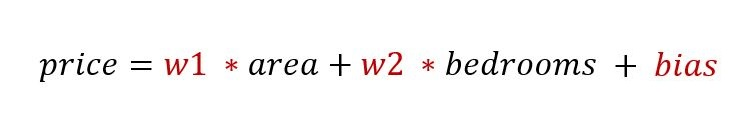

Now is the time to implement mini batch gradient descent.

In [7]:
def batch_gradient_descent(X, y_true, epochs, learning_rate = 0.01):

    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 2 (area, bedroom)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0] # number of rows in X
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):        
        y_predicted = np.dot(w, X.T) + b

        w_grad = -(2/total_samples)*(X.T.dot(y_true-y_predicted))
        b_grad = -(2/total_samples)*np.sum(y_true-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.mean(np.square(y_true-y_predicted)) # MSE (Mean Squared Error)
        
        if i%10==0:
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w, b, cost, cost_list, epoch_list = batch_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),500)
w, b, cost

(array([0.70712464, 0.67456527]), -0.23034857438407427, 0.0068641890429808105)

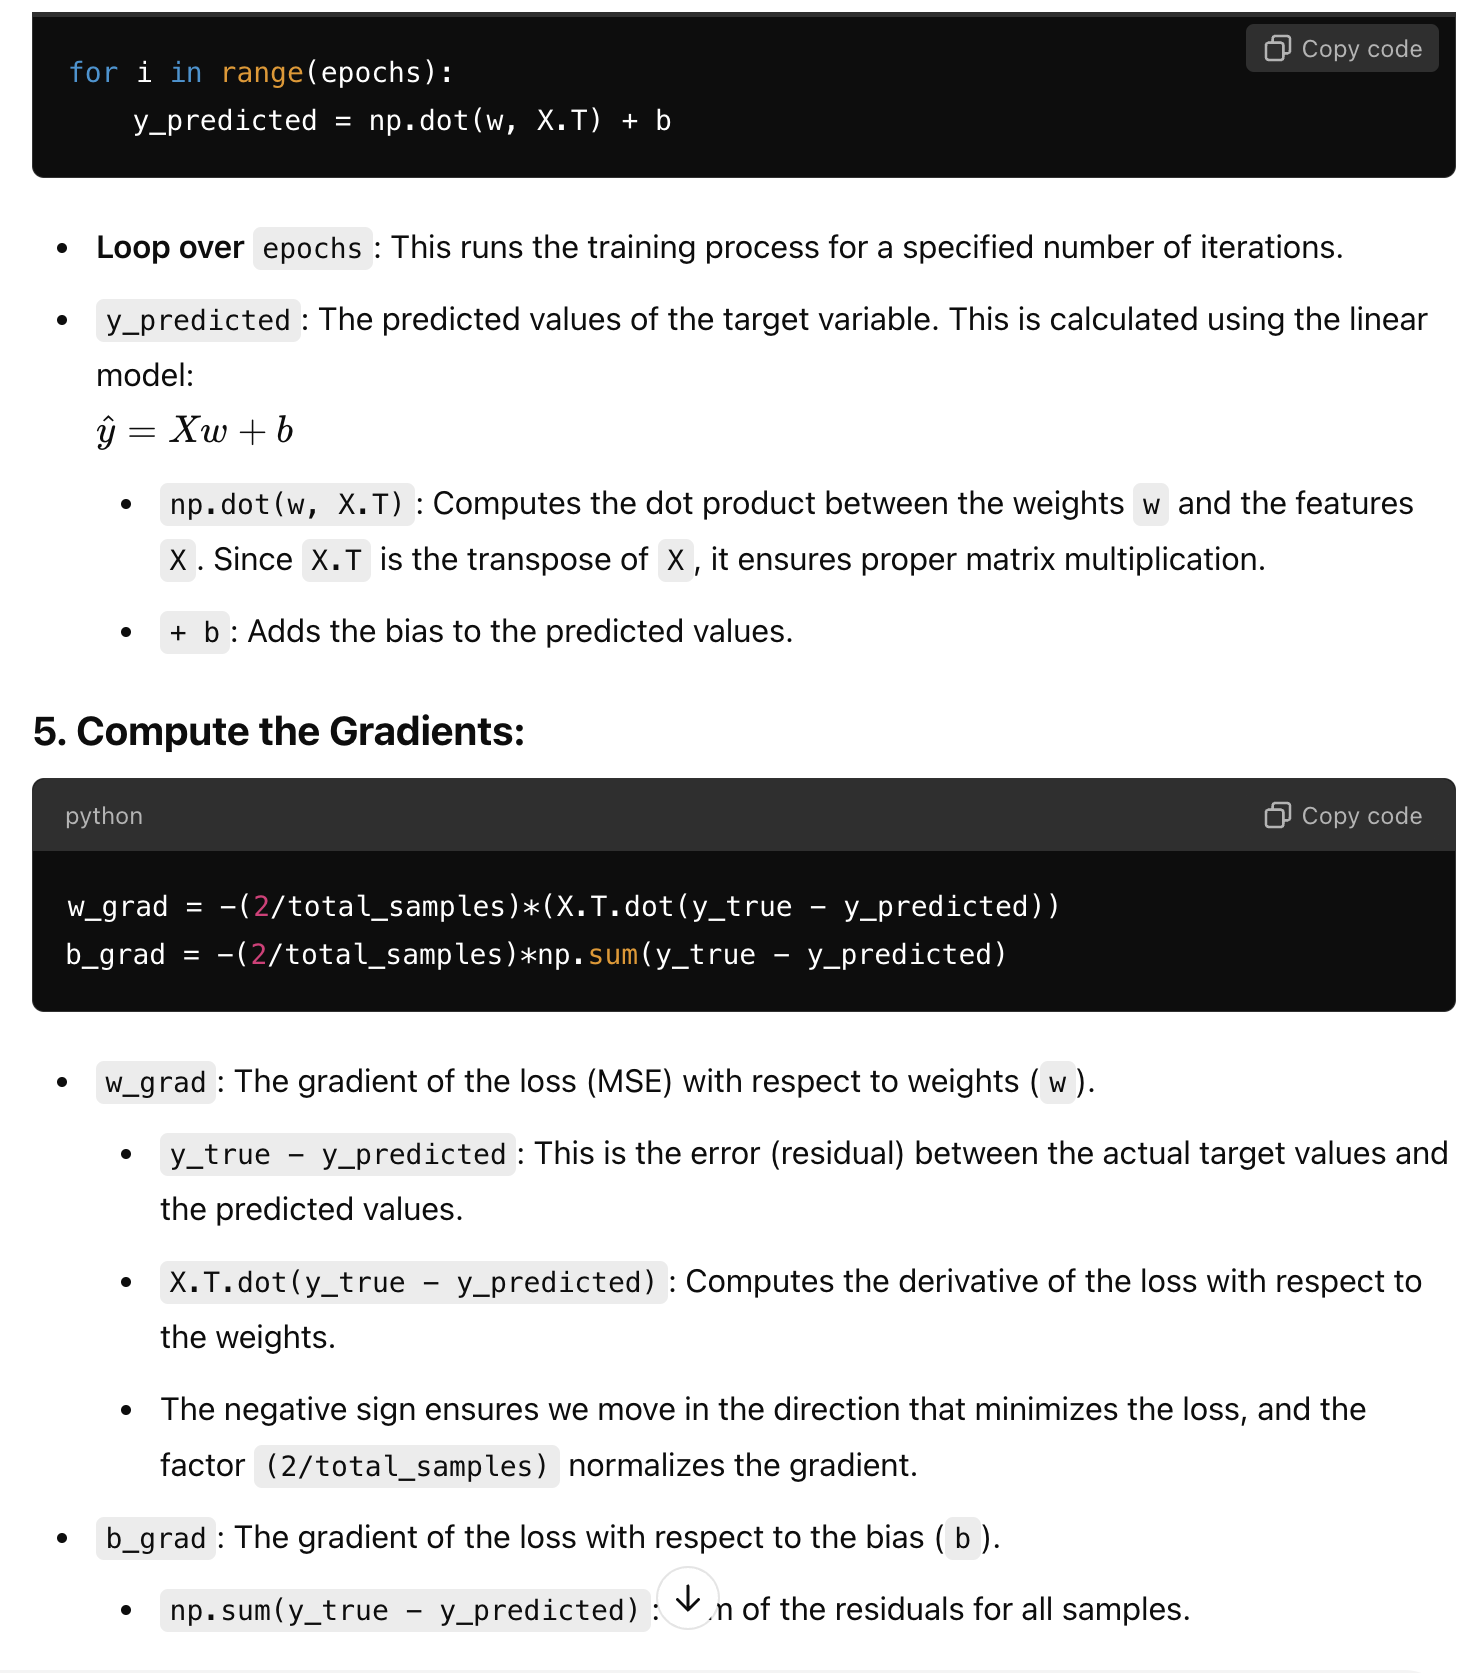

Check price equation above. In that equation we were trying to find values of w1,w2 and bias. Here we got these values for each of them,
w1 = 0.66469087 w2 = 0.60541671 bias = -0.17792104056392882

Now plot epoch vs cost graph to see how cost reduces as number of epoch increases

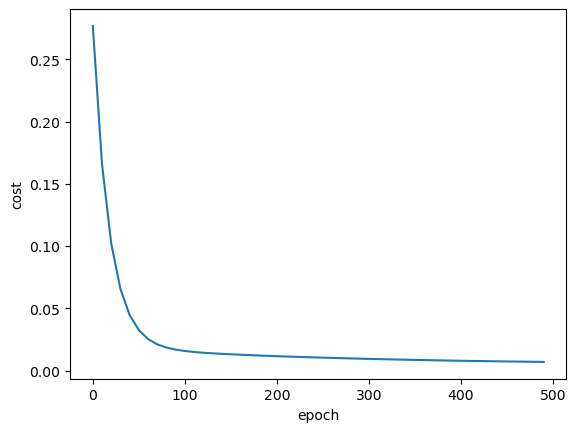

In [8]:
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list,cost_list)

In [9]:
def predict(area,bedrooms,w,b):
    scaled_X = sx.transform([[area, bedrooms]])[0]
    # here w1 = w[0] , w2 = w[1], w3 = w[2] and bias is b
    # equation for price is w1*area + w2*bedrooms + w3*age + bias
    # scaled_X[0] is area
    # scaled_X[1] is bedrooms
    # scaled_X[2] is age
    scaled_price = w[0] * scaled_X[0] + w[1] * scaled_X[1] + b
    # once we get price prediction we need to to rescal it back to original value
    # also since it returns 2D array, to get single value we need to do value[0][0]
    return sy.inverse_transform([[scaled_price]])[0][0]

predict(2600,4,w,b)

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


128.45484403267596

In [10]:
predict(1000,2,w,b)

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


30.253094462442355

# (2) Stochastic Gradient Descent Implementation

Stochastic GD will use randomly picked single training sample to calculate error and using this error we backpropage to adjust weights

In [11]:
# we will use random libary to pick random training sample.
import random
random.randint(0,6) # randit gives random number between two numbers specified in the argument

2

In [13]:
def stochastic_gradient_descent(X, y_true, epochs, learning_rate = 0.01):
 
    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 3 (area, bedroom and age)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0]
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):    
        random_index = random.randint(0,total_samples-1) # random index from total samples
        sample_x = X[random_index]
        sample_y = y_true[random_index]
        
        y_predicted = np.dot(w, sample_x.T) + b
    
        w_grad = -(2/total_samples)*(sample_x.T.dot(sample_y-y_predicted))
        b_grad = -(2/total_samples)*(sample_y-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.square(sample_y-y_predicted)
        
        if i%100==0: # at every 100th iteration record the cost and epoch value
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w_sgd, b_sgd, cost_sgd, cost_list_sgd, epoch_list_sgd = stochastic_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),10000)
w_sgd, b_sgd, cost_sgd

(array([0.70762965, 0.67632727]), -0.23196421834275754, 0.0002910936796676002)

Compare this with weights and bias that we got using gradient descent. They both of quite similar.

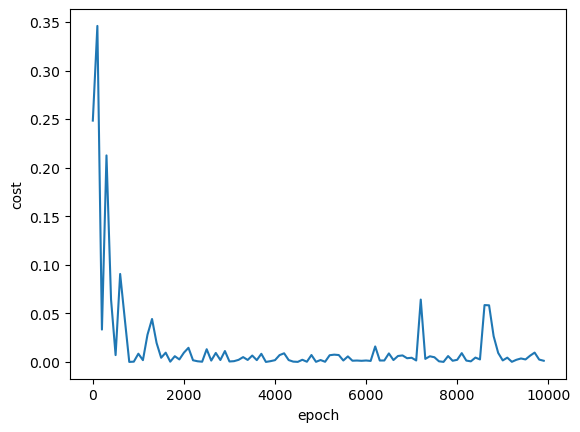

In [14]:
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list_sgd,cost_list_sgd)

In [15]:
predict(2600,4,w_sgd, b_sgd) 

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


128.45745127647515

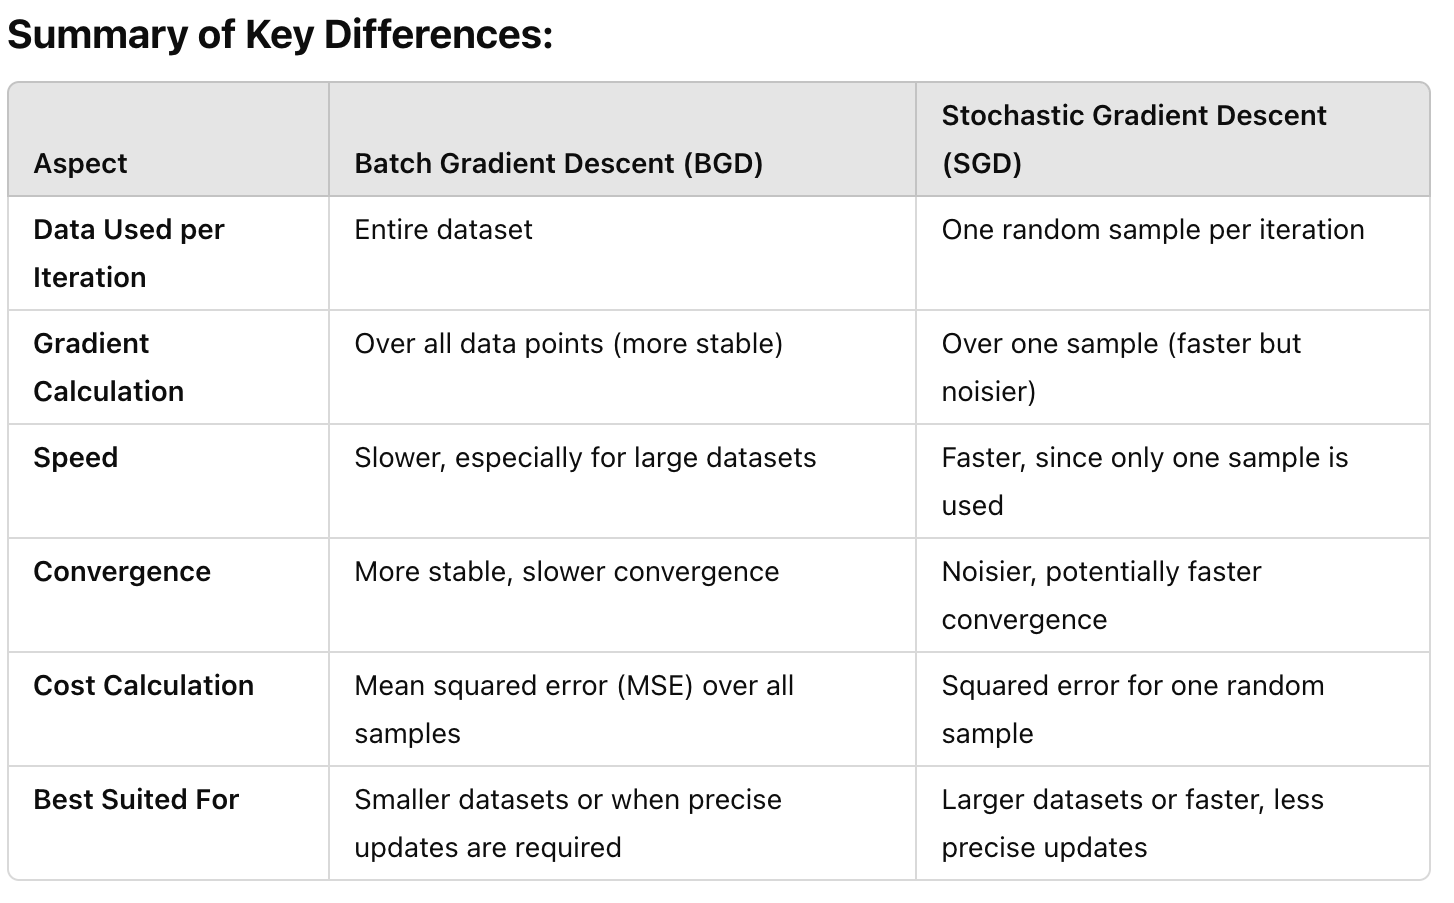

## Exercise

Implement mini batch gradient descent in python and plot cost vs epoch graph. Mini batch is intermediate version of batch GD and stochastic GD. In stochastic we used one randomly picked training sample, In mini gradient descent you will use a batch of samples in each iterations. For example if you have total 50 training samples, you can take a batch of 10 samples, calculate cumulitive error for those 10 samples and then adjust weights. In SGD we adjust weights after every one sample. In Batch we adjust weights after going through all samples but in mini batch we do after every m samples (where m is batch size and it is 0 < m < n, where n is total number of samples

In [18]:
import numpy as np
import random

def mini_batch_gradient_descent(X, y_true, epochs, batch_size=32, learning_rate=0.01):
 
    number_of_features = X.shape[1]  # Number of features (e.g., area, bedroom, age)
    w = np.ones(shape=(number_of_features))  # Initialize weights
    b = 0  # Initialize bias
    total_samples = X.shape[0]  # Total number of samples in the dataset
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):  
        # Create mini-batches
        indices = np.random.permutation(total_samples)  # Shuffle the dataset indices
        X_shuffled = X[indices]
        y_shuffled = y_true[indices]
        
        # Loop over mini-batches
        for start in range(0, total_samples, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]  # Mini-batch of input features
            y_batch = y_shuffled[start:end]  # Mini-batch of true labels
            
            # Prediction for the mini-batch
            y_predicted = np.dot(X_batch, w.T) + b

            # Calculate gradients based on the mini-batch
            w_grad = -(2 / batch_size) * np.dot(X_batch.T, (y_batch - y_predicted))
            b_grad = -(2 / batch_size) * np.sum(y_batch - y_predicted)
        
            # Update weights and bias
            w = w - learning_rate * w_grad
            b = b - learning_rate * b_grad
        
        # Calculate cost at the end of each epoch
        total_predicted = np.dot(X, w.T) + b  # Predict using updated weights for all samples
        cost = np.mean(np.square(y_true - total_predicted))  # MSE over the entire dataset
        
        if i % 100 == 0:  # At every 100th epoch, record the cost and epoch value
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

# Run mini-batch gradient descent
w_mbgd, b_mbgd, cost_mbgd, cost_list_mbgd, epoch_list_mbgd = mini_batch_gradient_descent(scaled_X, scaled_y.reshape(scaled_y.shape[0],), 10000, batch_size=32)
w_mbgd, b_mbgd, cost_mbgd


(array([0.78281452, 0.38084003]), -0.10981875748277777, 0.003263375866300551)

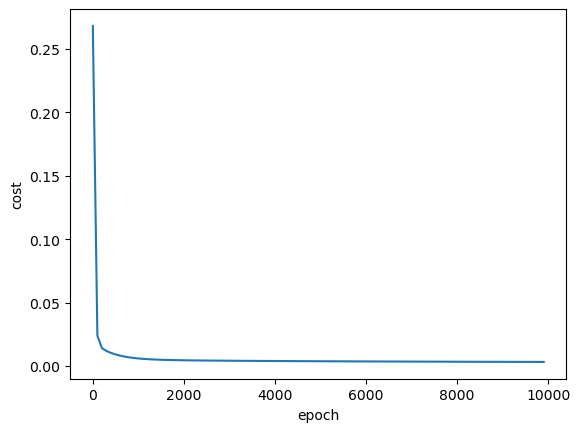

In [19]:
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list_mbgd,cost_list_mbgd)